# Project Title: Sales Predictions Model

- Author: Osmayda Nino

## Project Overview

This project will be a sales prediction for food items sold at various stores. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

**Data Dictionary for this dataset**

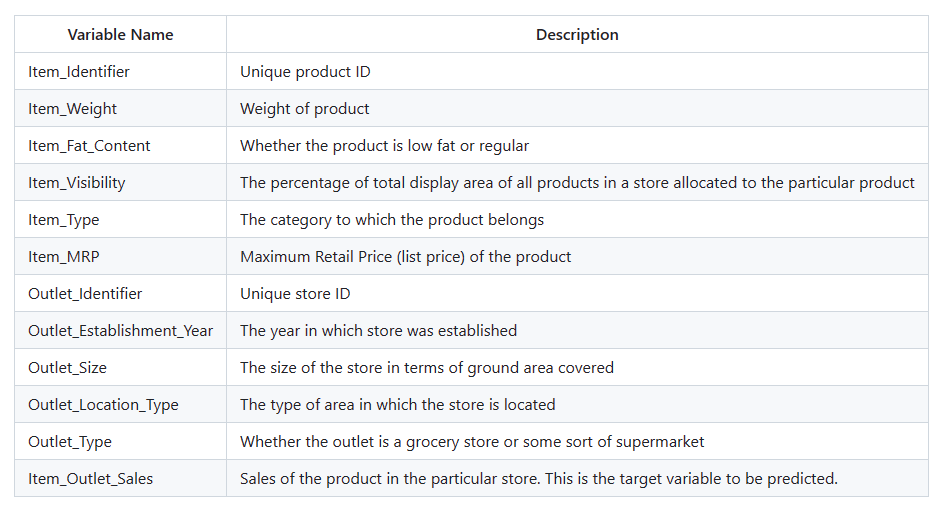

# Import Libraries | Load Data

## Import Libraries

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
price_fmt = StrMethodFormatter("${x:,.0f}")

import seaborn as sns
sns.set_style('white')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

set_config(display='diagram')

# Load Data

In [2]:
df = pd.read_csv("Data/sales_predictions_2023.csv") 

# Summary of the DataFrame's Columns and preview the first row of data 
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


## Clean Data

In [5]:
# The number  of rows and columns of the DataFrame
df.shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 8523 rows and 12 columns.
The rows represent 8523 observations and the columns represent 11 features and 1 target variable.


In [8]:
# The .dtype attribute returns a Series with the data type of each column
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- The dataset has a combination of categorical (object) and numberic (float and int) data types.

### Duplicates

In [6]:
# Check data for duplicates
df.duplicated().sum()

0

- No duplicates found to be dropped. 

### Missing Values

In [10]:
# Identifing missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Item_Weight and Outlet_Size have some missing(null) values. 

- **Impute missing values with an average of that column. The item weight and the size of the outlet are import information for retailer to understand how properties of products play crucial roles in increasing sales.**

### Handling Null Values

#### Cleaning Missing Item_Weight

- Item_Weight is a numerical value, we should be able to use mean, median, or mode to impute values.

 - will use median to impute values

In [16]:
# Impute average for Item_Weight
median_item_weight = df['Item_Weight'].median()
df['Item_Weight'].fillna(median_item_weight, inplace=True)

#### Cleaning Missing Outlet_Size

- Outlet-Size is missing 2410 values out of 8523.

In [17]:
# Checking for unique values
pd.unique(df['Outlet_Size'])

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [19]:
# Missing values will be replaced with "missing" for Outlet_Size
df['Outlet_Size'].fillna("missing", inplace=True)

In [20]:
# Confirm there are no missing values after addressing them
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Inspect Columns with Object Datatypes

- Check for common syntax errors which may include extra white spaces at the beginning or end of strings or column names.

- Check for typos or inconsistencies in strings that need to be fixed.

In [23]:
# Inspect column names for Errors
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [25]:
# Checking for common syntax errors, typos, inconsistencies in strings that need to be fixed
# Create a series of the datatypes
data_types = df.dtypes
# Create a filter to select only the object datatypes
object_data_types = data_types[(data_types == 'object')]
# Display the series of object datatypes
object_data_types

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

In [27]:
# Loop through the index of object_data_types
for column in object_data_types.index:
  print(column)
  print(df[column].unique())
  print('\n')

Item_Identifier
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']


Item_Fat_Content
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


Outlet_Identifier
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


Outlet_Size
['Medium' 'missing' 'High' 'Small']


Outlet_Location_Type
['Tier 1' 'Tier 3' 'Tier 2']


Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']




#### Fixing inconsistencies with Item_Fat_Content

In [30]:
df.groupby(['Item_Fat_Content'])['Item_Fat_Content'].count()

Item_Fat_Content
LF          316
Low Fat    5089
Regular    2889
low fat     112
reg         117
Name: Item_Fat_Content, dtype: int64

- Replace 'LF' and 'low fat' with 'Low Fat'
- Replace 'reg' with 'Regular'

In [31]:
# Defining a dictionary with key/value pairs and using it to replace values
dict = {"low fat": 'Low Fat', "reg": 'Regular', "LF": 'Low Fat'}
df.replace({'Item_Fat_Content': dict}, inplace = True)

In [35]:
# Confirm Item_Fat_Content has been normalized
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Inspect Columns with Numerical Datatypes

- Filter columns with numerical indexes to obtain summary statistics (min, max, mean).

In [36]:
# Summary statistics for Numeric Columns
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914
std,4.22724,0.051598,62.275067,8.371760,1706.499616
min,4.55500,0.000000,31.290000,1985.000000,33.290000
25%,9.31000,0.026989,93.826500,1987.000000,834.247400
50%,12.60000,0.053931,143.012800,1999.000000,1794.331000
75%,16.00000,0.094585,185.643700,2004.000000,3101.296400
max,21.35000,0.328391,266.888400,2009.000000,13086.964800


- No unusual statistics noted. 

## Feature Inspection